In [49]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer ,ENGLISH_STOP_WORDS

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
import re 
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# 1- Make a data set with all emotions

### Merge The two datasets to get neutral emotion 

In [50]:
df1 = pd.read_csv('./First Data/training.csv')
df1.shape

(16000, 2)

In [51]:
df3 = pd.read_csv('./Third Data/tweet_emotions.csv')
df3.shape

(40000, 3)

In [52]:
df3 = df3[df3.sentiment == 'neutral'] 

df3.shape

(8638, 3)

In [53]:
df3=df3[:200]
df3.shape

(200, 3)

In [54]:
df3.head()

,tweet_id,sentiment,content
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
10,1956969456,neutral,cant fall asleep
22,1956972116,neutral,No Topic Maps talks at the Balisage Markup Con...
31,1956975441,neutral,@cynthia_123 i cant sleep
32,1956975860,neutral,I missed the bl***y bus!!!!!!!!


### Drop the id column

In [55]:
df3.drop(['tweet_id'],axis=1,inplace = True)

In [56]:
df3.head()

,sentiment,content
4,neutral,@dannycastillo We want to trade with someone w...
10,neutral,cant fall asleep
22,neutral,No Topic Maps talks at the Balisage Markup Con...
31,neutral,@cynthia_123 i cant sleep
32,neutral,I missed the bl***y bus!!!!!!!!


### Rename the coulmns names


In [57]:
df3.rename(
    columns={"sentiment":"label",
                "content":"text",
                   }
          ,inplace=True)
df3.head()

,label,text
4,neutral,@dannycastillo We want to trade with someone w...
10,neutral,cant fall asleep
22,neutral,No Topic Maps talks at the Balisage Markup Con...
31,neutral,@cynthia_123 i cant sleep
32,neutral,I missed the bl***y bus!!!!!!!!


### insert value 6 insted of neutral word

In [58]:
df3.label =int(6) 
df3.head()

,label,text
4,6,@dannycastillo We want to trade with someone w...
10,6,cant fall asleep
22,6,No Topic Maps talks at the Balisage Markup Con...
31,6,@cynthia_123 i cant sleep
32,6,I missed the bl***y bus!!!!!!!!


### Concat the two datasets

In [59]:
df = pd.concat([df1, df3], ignore_index = True, axis = 0)
df.shape

(16200, 2)

### shuffle the data set 

In [60]:
df=df.sample(frac = 1)

In [61]:
df.head()
#label_dict = {0:'sad', 1:'happy', 2:'love', 3:'angry', 4:'fear', 5:'surprise',6:'neutral'}


,text,label
8761,i fall off when my uncle hits so i cant imagin...,1
12113,im starting to feel that im suffering from fat...,0
2435,i am still feeling passionate progressive and ...,2
8727,i won t say that i didn t feel any fear becaus...,5
8499,i am starting to feel a little more welcomed i...,1


### drop the fear and surprise emotions

In [62]:
df = df[df.label != 4] #& 'boredom' & 'enthusiasm' & 'empty'
df = df[df.label != 5]

df = df[df.label != 'sentiment']
df.head()

/home/paula/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,text,label
8761,i fall off when my uncle hits so i cant imagin...,1
12113,im starting to feel that im suffering from fat...,0
2435,i am still feeling passionate progressive and ...,2
8499,i am starting to feel a little more welcomed i...,1
3976,i guess a lot of her is pretty high even thoug...,0


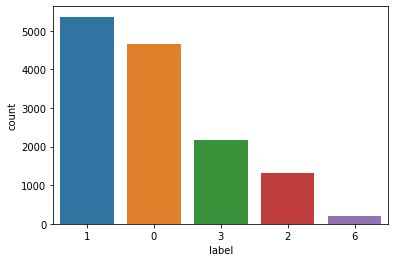

In [63]:
#label_dict = {0:'sad', 1:'happy', 2:'love', 3:'angry',6:'neutral'}

sns.countplot(df['label'],order = df['label'].value_counts(normalize=True).index)

# Data Preprocessing

1- clean any HTML tags in the text

In [64]:
def clean_html(text):
    
    clean = re.compile('<.*?>')
    return re.sub(clean, '',text)
    
df['text']=df['text'].apply(clean_html)
df.head()

,text,label
8761,i fall off when my uncle hits so i cant imagin...,1
12113,im starting to feel that im suffering from fat...,0
2435,i am still feeling passionate progressive and ...,2
8499,i am starting to feel a little more welcomed i...,1
3976,i guess a lot of her is pretty high even thoug...,0


2- convert all the text into lower case 

In [65]:
def convert_lower(text):
    return text.lower()

df['text']=df['text'].apply(convert_lower)
df.head()

,text,label
8761,i fall off when my uncle hits so i cant imagin...,1
12113,im starting to feel that im suffering from fat...,0
2435,i am still feeling passionate progressive and ...,2
8499,i am starting to feel a little more welcomed i...,1
3976,i guess a lot of her is pretty high even thoug...,0


3- clean the Tag sign and Tag name (ex:@Paula)

In [66]:
def cleaning_tags(text):
    return ' '.join(re.sub("([@#][A-Za-z0-9_]+)|(\w+:\/\/\S+)"," ", text).split())

df['text'] = df['text'].apply(lambda x: cleaning_tags(x))
df['text'].head()

8761     i fall off when my uncle hits so i cant imagin...
12113    im starting to feel that im suffering from fat...
2435     i am still feeling passionate progressive and ...
8499     i am starting to feel a little more welcomed i...
3976     i guess a lot of her is pretty high even thoug...
Name: text, dtype: object

4- clean all the punctuations  

In [67]:

english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
df['text']= df['text'].apply(lambda x: cleaning_punctuations(x))
df['text'].head()

8761     i fall off when my uncle hits so i cant imagin...
12113    im starting to feel that im suffering from fat...
2435     i am still feeling passionate progressive and ...
8499     i am starting to feel a little more welcomed i...
3976     i guess a lot of her is pretty high even thoug...
Name: text, dtype: object

In [68]:
#def cleaning_repeating_char(text):
 #   return re.sub(r'([a-z])\1+', r'\1', text)
#df['text'] = df['text'].apply(lambda x: cleaning_repeating_char(x))
#df['text'].head()

5- clean the urls founded in the tweets


In [69]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
df['text'] = df['text'].apply(lambda x: cleaning_URLs(x))
df['text'].head()

8761     i fall off when my uncle hits so i cant imagin...
12113    im starting to feel that im suffering from fat...
2435     i am still feeling passionate progressive and ...
8499     i am starting to feel a little more welcomed i...
3976     i guess a lot of her is pretty high even thoug...
Name: text, dtype: object

6- clean all numbers 

In [70]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
df['text'] = df['text'].apply(lambda x: cleaning_numbers(x))
df['text'].head()

8761     i fall off when my uncle hits so i cant imagin...
12113    im starting to feel that im suffering from fat...
2435     i am still feeling passionate progressive and ...
8499     i am starting to feel a little more welcomed i...
3976     i guess a lot of her is pretty high even thoug...
Name: text, dtype: object

7-remove stopwords from data

In [71]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df.head()

[nltk_data] Downloading package stopwords to /home/paula/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label
8761,fall uncle hits cant imagine must feel like go...,1
12113,im starting feel im suffering fatigue,0
2435,still feeling passionate progressive motivated...,2
8499,starting feel little welcomed sessions,1
3976,guess lot pretty high even though feel hiccups...,0


8- stemming words in data

In [72]:
from nltk.stem.porter import PorterStemmer
ps= PorterStemmer()
y=[]

def stem_words(text):
    for i in text:
        y.append(ps.stem(i))
    z=y[:]
    y.clear()
    return z
df['text']=df['text'].apply(stem_words)
df.head()

,text,label
8761,"[f, a, l, l, , u, n, c, l, e, , h, i, t, s, ...",1
12113,"[i, m, , s, t, a, r, t, i, n, g, , f, e, e, ...",0
2435,"[s, t, i, l, l, , f, e, e, l, i, n, g, , p, ...",2
8499,"[s, t, a, r, t, i, n, g, , f, e, e, l, , l, ...",1
3976,"[g, u, e, s, s, , l, o, t, , p, r, e, t, t, ...",0


9- join back after stemming

In [73]:
def joinback2(list_input):
    return "".join(list_input)
    


df['text']=df['text'].apply(joinback2)
df.head()



,text,label
8761,fall uncle hits cant imagine must feel like go...,1
12113,im starting feel im suffering fatigue,0
2435,still feeling passionate progressive motivated...,2
8499,starting feel little welcomed sessions,1
3976,guess lot pretty high even though feel hiccups...,0


### Exploratory data analysis 

1- Sad Emotion

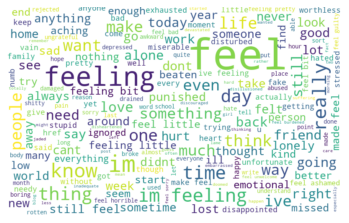

In [74]:
txt = ' '.join(text for text in df[df['label']==0]['text'])

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 200,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

2- Happy Emotion

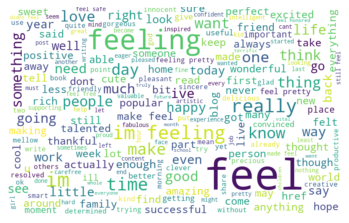

In [75]:
txt = ' '.join(text for text in df[df['label']==1]['text'])

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 200,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

3- Love Emotion

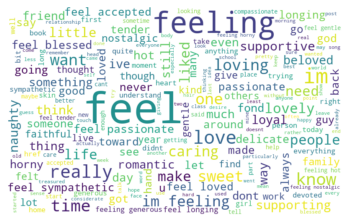

In [76]:
txt = ' '.join(text for text in df[df['label']==2]['text'])

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 200,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

4-Angry Emotion

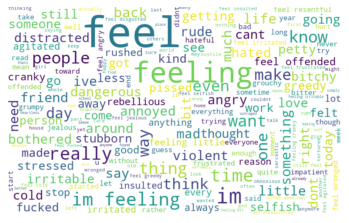

In [77]:
txt = ' '.join(text for text in df[df['label']==3]['text'])

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 200,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

5- Neutral Emotion

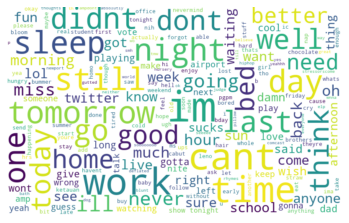

In [78]:
txt = ' '.join(text for text in df[df['label']==6]['text'])

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 200,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### split data 

In [79]:
X=df['text']
y=df.label
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3) 

### Transfer data into numerical features using TFIDF

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(binary=True, use_idf=True)
X_train = vec.fit_transform(X_train) 
X_test = vec.transform(X_test)

In [81]:
X_test.shape

(4108, 11542)

### Try first model passive aggressive classfier

In [82]:
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(X_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

In [83]:
y_pred=pac.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')


Accuracy: 89.85%


### Try second model : logistic regression

In [84]:
log_reg = LogisticRegression(max_iter=50).fit(X_train, y_train)


/home/paula/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [85]:
y_predicted = log_reg.predict(X_test)
score=accuracy_score(y_test,y_predicted)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 88.17%


### Try third model : xgboost 

In [86]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100,learning_rate=0.2)

In [87]:
model.fit(X_train, y_train)


[23:12:32] WARNING: /workspace/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [88]:
y_pred = model.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 89.63%


### Testing

In [48]:

Lines=["Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"]
#Lines = cv.transform(Lines)
Lines =vec.transform(Lines)
scores = pac.predict(Lines)  
#Prob score for both classes (Good/bad) 
score = scores[0]
if score == 0:
    print('The post is sad')
elif score ==1:
    print('The post is happy')
elif score == 2:
     print('The post is Love')
elif score == 3 :
    print('The post is anger')

elif score == 6 :
    print('the post is Neutral ')

the post is Neutral 


In [89]:

model.save_model("best_classicalmodel.json")


In [94]:
model2 = XGBClassifier()
model2.load_model("best_classicalmodel.json")

In [95]:
Lines=["Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"]
#Lines = cv.transform(Lines)
Lines =vec.transform(Lines)
scores = model2.predict(Lines)  
print(scores)

[6]
